In [1]:
import pickle
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_paper/"
res_DIR = "../data/results_paper/"
resistance_DIR = "../data/resistance/"
# %matplotlib widget

In [2]:
def plotc2_cap(all_sumvars_dict1,all_sumvars_dict2,esoh_data,leg1="sim1",leg2="sim2"):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    name = "Capacity [A.h]"
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"b--")
    ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"r--")
    ax.plot(esoh_data["N"],esoh_data[name],"kx")
    ax.set_title(split_long_string(name))
    ax.set_xlabel("Cycle number")
    fig.legend([leg1, leg2 , "Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=3, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
cells = [1,4,7,10,13,16,19]
# cells = [19]
for cell in cells:
    sno = 1
    sim_des = f'cond{sno}'
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data1 = pickle.load(handle)
    sno = 6
    sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data2 = pickle.load(handle)
    fig = plotc2_cap(data1,data2,dfe,leg1="Old",leg2="New Mech Damage");
    fig.savefig(fig_DIR +'com_mech_damage_model_cell_'+cell_no+'_cap.png')

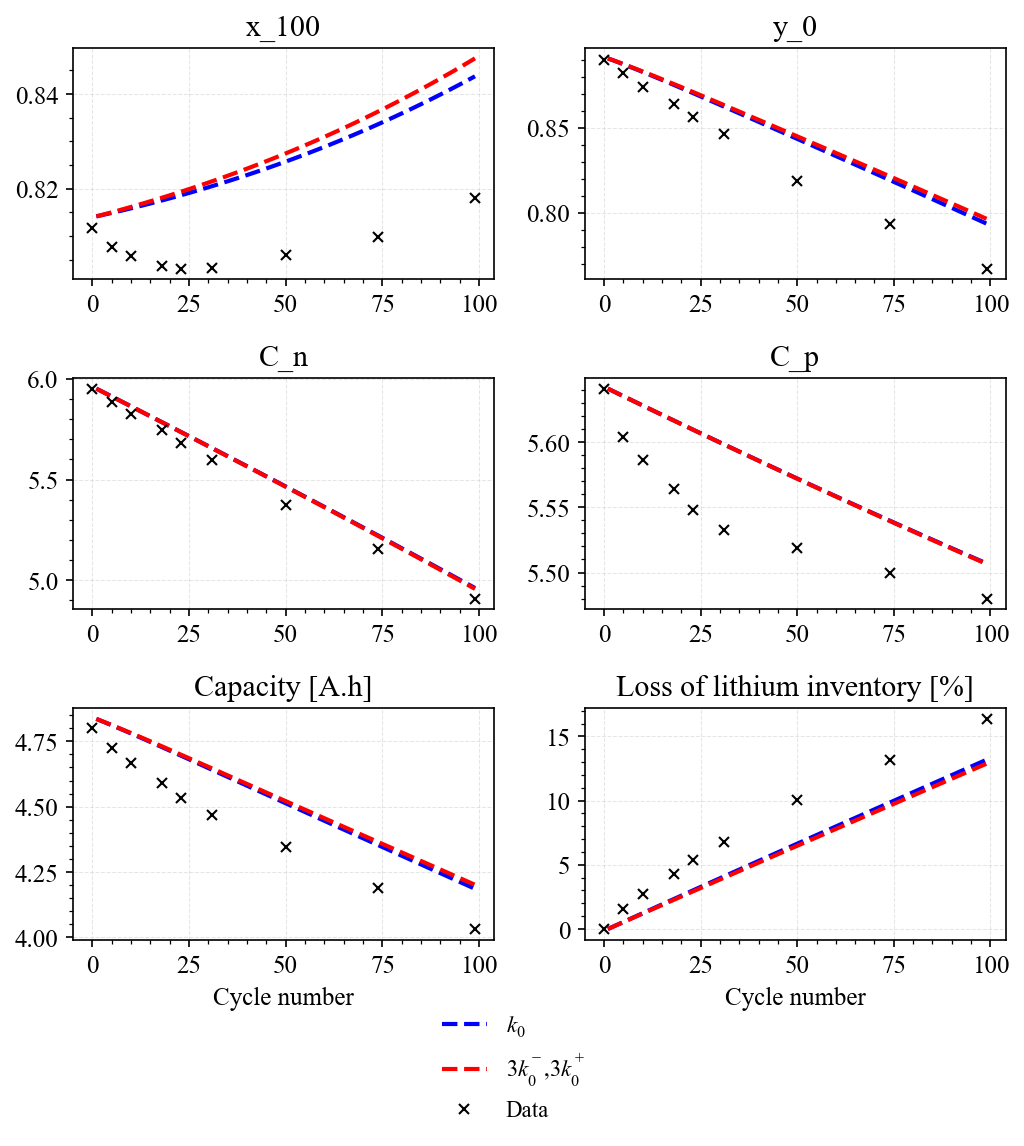

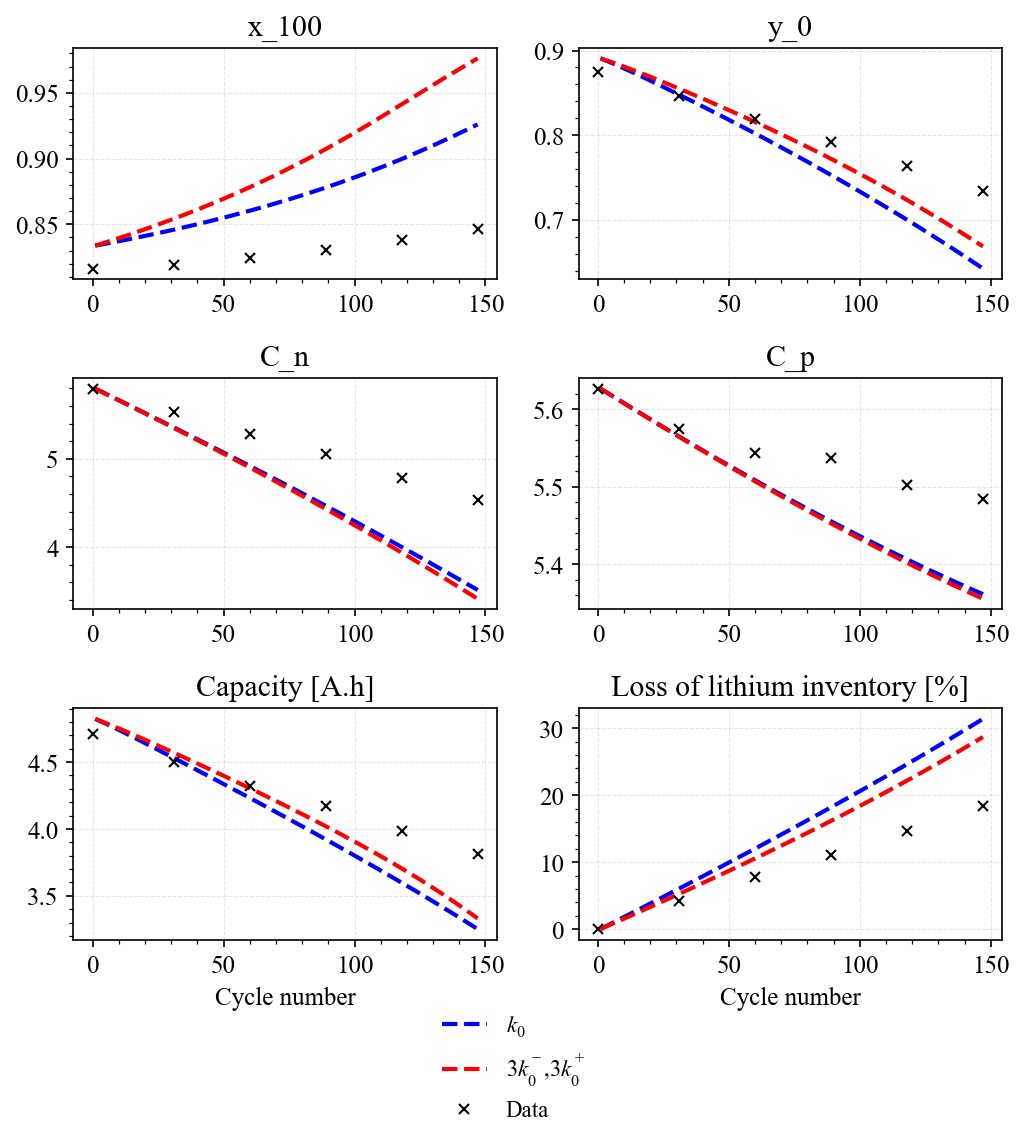

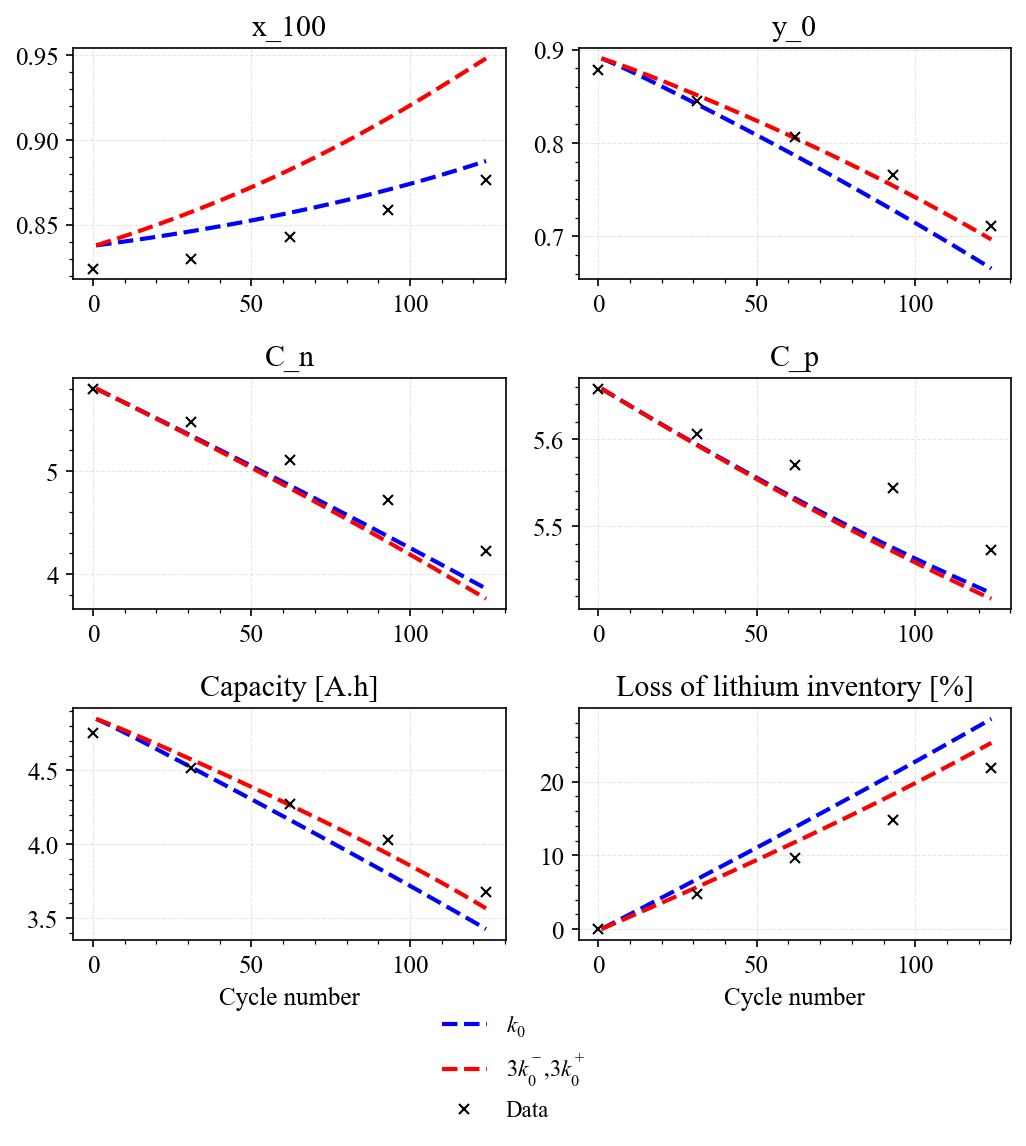

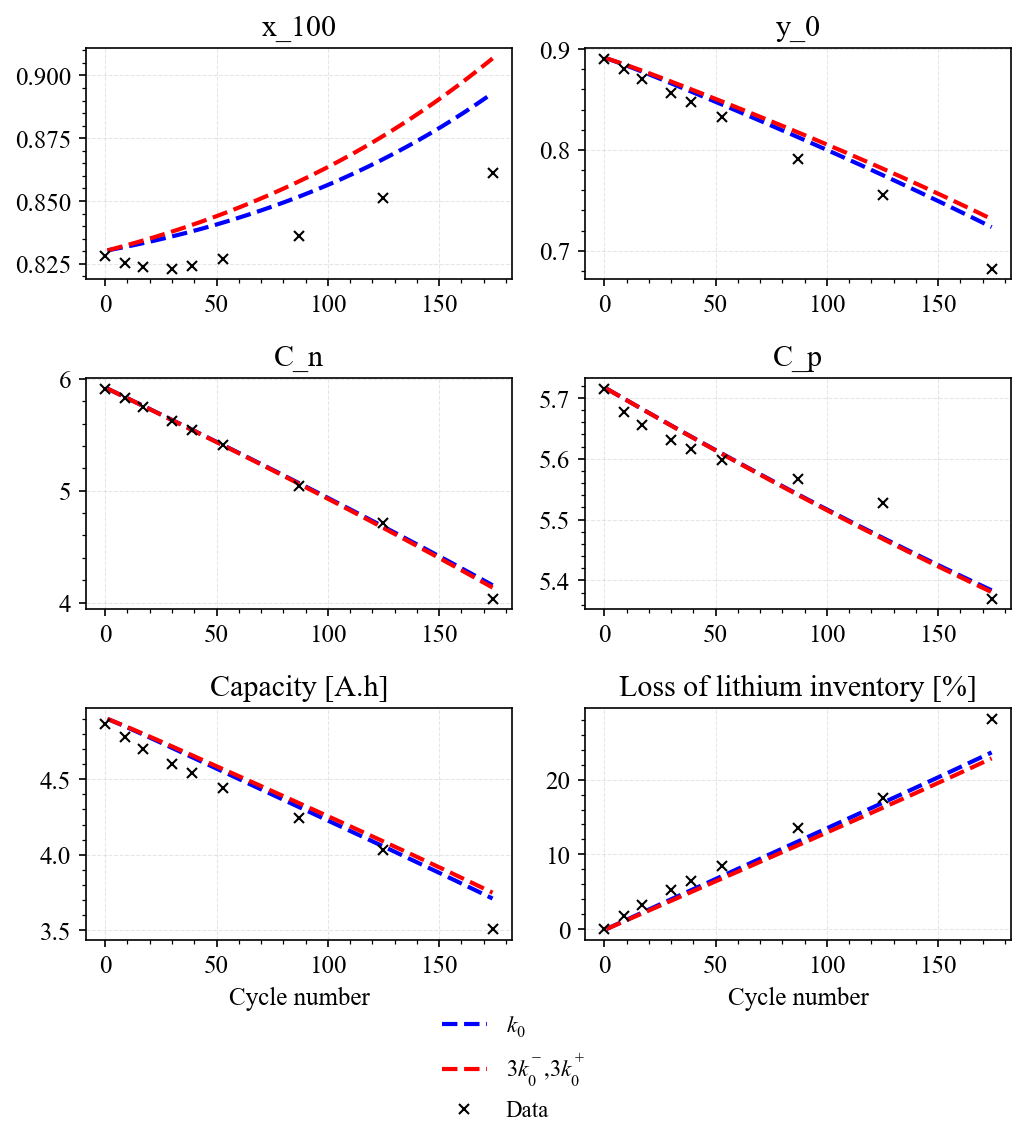

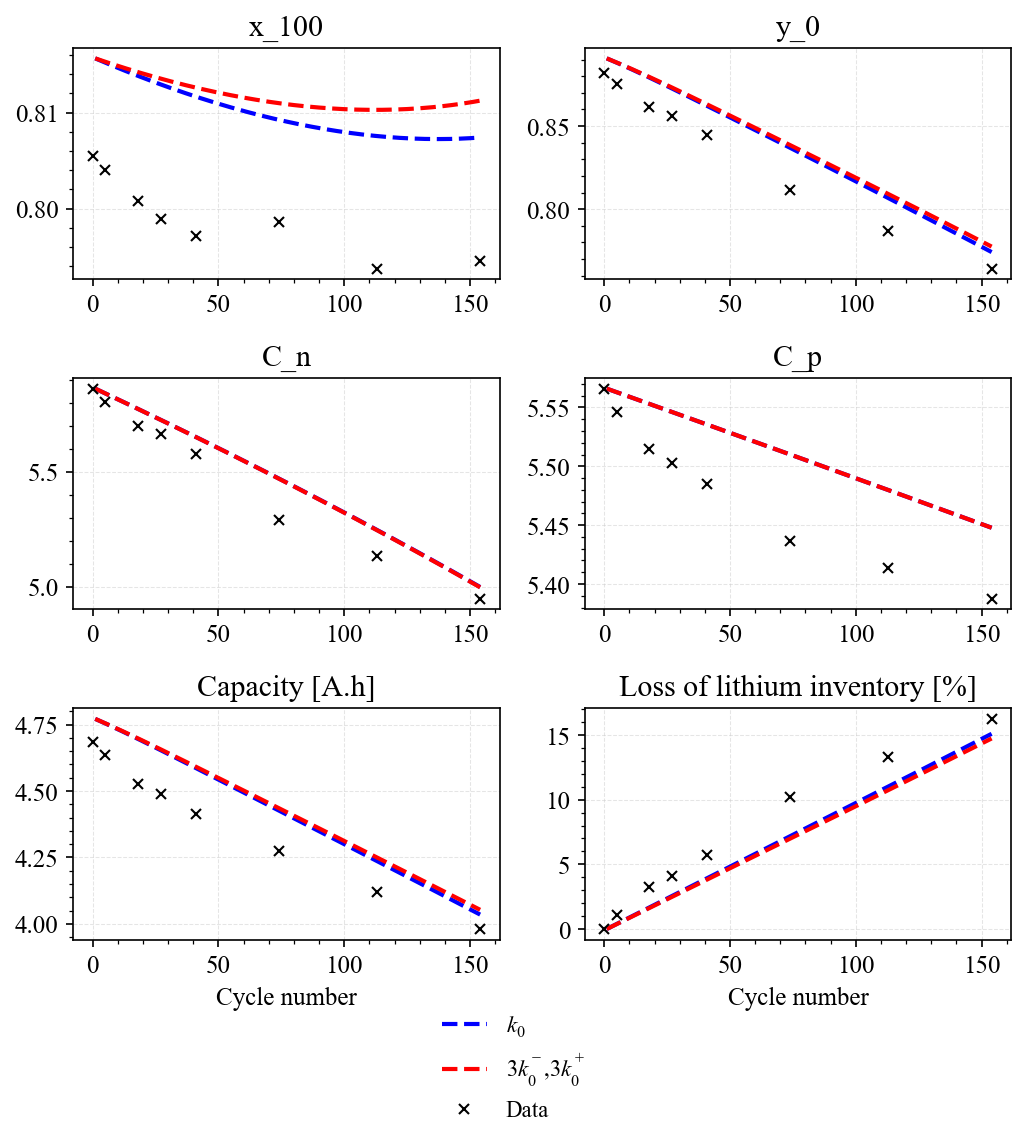

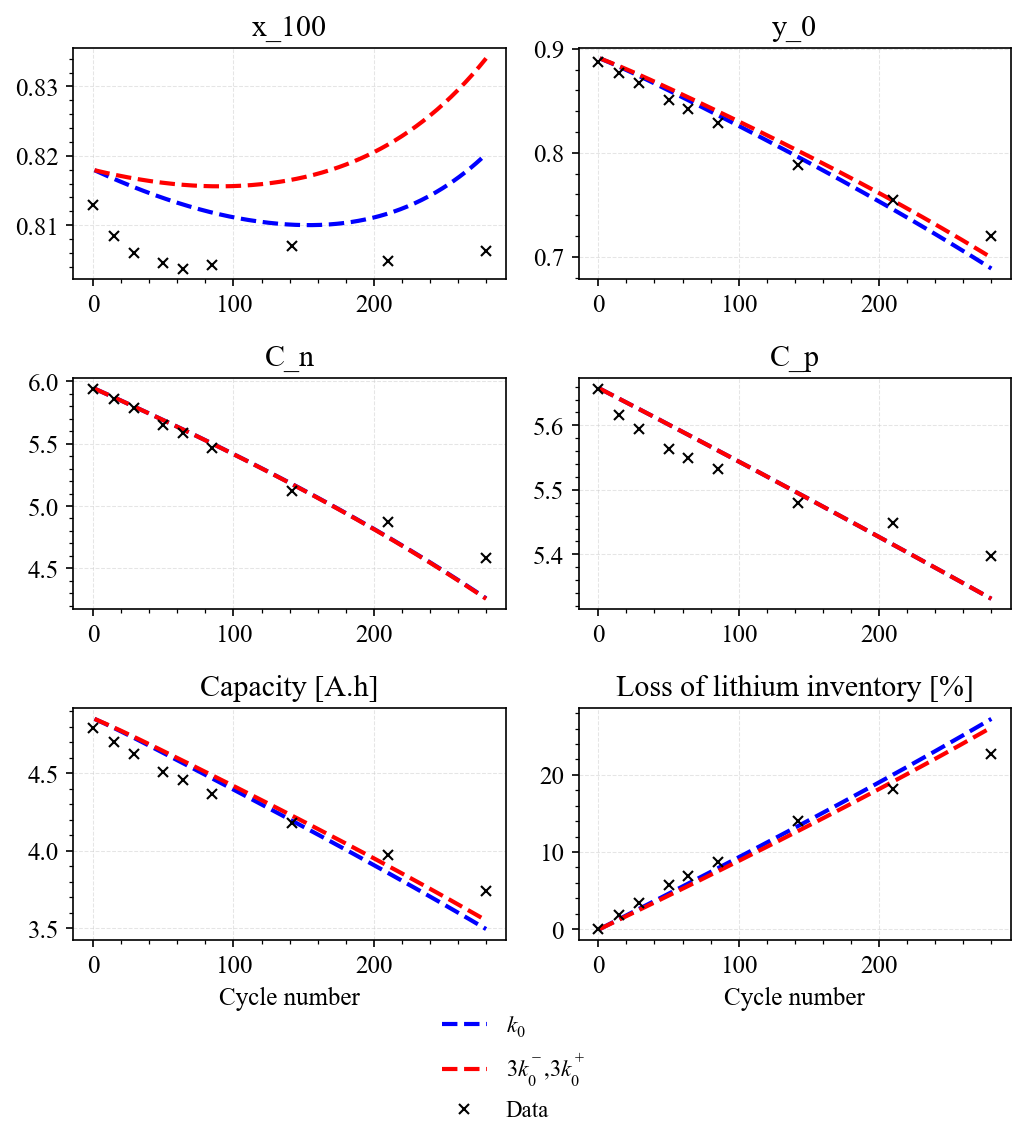

In [15]:
cells = [1,4,7,10,13,16,19]
cells = [3,6,9,12,15,18]
for cell in cells:
    sno = 7
    sim_des = f'cond{sno}'
    sim_des = sim_des+'_io_1'
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data1 = pickle.load(handle)
    sno = 7
    sim_des = f'cond{sno}'
    sim_des = sim_des+'_io_2'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data2 = pickle.load(handle)
    fig = plotc2(data1,data2,dfe,leg1=r"$k_{0}$",leg2=r"3$k^-_{0}$,3$k^+_{0}$");
    fig.savefig(fig_DIR +'com_exch_current_cell_'+cell_no+'_eSOH.png')

# Cycling Voltage

In [ ]:
asdasdasd

In [ ]:
def load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if cell == 1:
        offset = 12
    else:
        offset = 0
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-1]-offset
    else:
        N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[:idx_I[0]]
    V = V_c1[:idx_I[0]]
    I = I_c1[:idx_I[0]]
    E = E_c1[:idx_I[0]]-E_c1[0]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [ ]:
def load_cycling_data_dh(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if cell == 1:
        offset = 12
    else:
        offset = 0
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-1]-offset
    else:
        N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[idx_I[0]:]-t_c1[idx_I[0]]
    V = V_c1[idx_I[0]:]
    I = I_c1[idx_I[0]:]
    E = E_c1[idx_I[0]:]-E_c1[idx_I[0]]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = -1*integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [ ]:
def get_rmse(t_d,V_d,E_d,t,Vt,Exp):
    if max(t)<max(t_d):
        int_V = interpolate.CubicSpline(t_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(t))
        int_E = interpolate.CubicSpline(t_d,E_d,extrapolate=True)
        rmse_E = pybamm.rmse(Exp,int_E(t))
        # int_VQ = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
        # rmse_VQ = pybamm.rmse(Vt,int_VQ(Q))
        # int_EQ = interpolate.CubicSpline(Q_d,E_d,extrapolate=True)
        # rmse_EQ = pybamm.rmse(Exp,int_EQ(Q))
    else:
        int_V = interpolate.CubicSpline(t,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(t_d))
        int_E = interpolate.CubicSpline(t,Exp,extrapolate=True)
        rmse_E = pybamm.rmse(E_d,int_E(t_d))
        # int_VQ = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        # rmse_VQ = pybamm.rmse(V_d,int_VQ(Q_d))
        # int_EQ = interpolate.CubicSpline(Q,Exp,extrapolate=True)
        # rmse_EQ = pybamm.rmse(E_d,int_EQ(Q_d))
    return rmse_V,rmse_E

In [ ]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df1 = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    # df2 = pd.read_csv(res_DIR + "volt_exp_sim_new_i0_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    ax1 = ax.flat[i]
    ax1.plot(t_d/3600,V_d,'k',linewidth=1)
    ax1.plot(df1['t']/3600,df1['Vt'],'b--',linewidth=1.5)
    # ax1.plot(df2['t']/3600,df2['Vt'],'r--',linewidth=1.5)
    ax1.set_xlabel('Time [h]')
    rmse_V1,rmse_E1 = get_rmse(t_d,V_d,E_d,df1['t'].to_numpy(),df1['Vt'].to_numpy(),df1['Exp'].to_numpy())
    rmse_V2,rmse_E2 = get_rmse(t_d,V_d,E_d,df2['t'].to_numpy(),df2['Vt'].to_numpy(),df2['Exp'].to_numpy())
    ax1.text(0.5,0.2,f'RMSE: {rmse_V1*1e3:0.1f} mV',transform=ax1.transAxes)
    # ax1.text(0.5,0.1,f'RMSE: {rmse_V2*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    # ax1.set_title('{} [N:{:0f},Ah Th:{:0f}, Cap Ret: {:0f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax2 = ax.flat[i+3]
    ax2.plot(t_d/3600,I_d,'k',linewidth=1)
    ax2.plot(df1['t']/3600,-df1['I'],'b--',linewidth=1.5)
    ax2.plot(df2['t']/3600,-df2['I'],'r--',linewidth=1.5)
    ax2.set_xlabel('Time [h]')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('$I$ [A]')
    i+=1
ax2.legend(["Data","Old Sim","new Sim"],ncol=1)
fig.suptitle('Cycling Voltage Charge')
fig.tight_layout()
plt.savefig(fig_DIR +'volt_error_comp_cell_'+cell_no+'_ch.png')
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch_Q.png')

# Plot Capacity Loss

In [ ]:
asda

In [2]:
sno = 7
sim_des = f'cond{sno}'

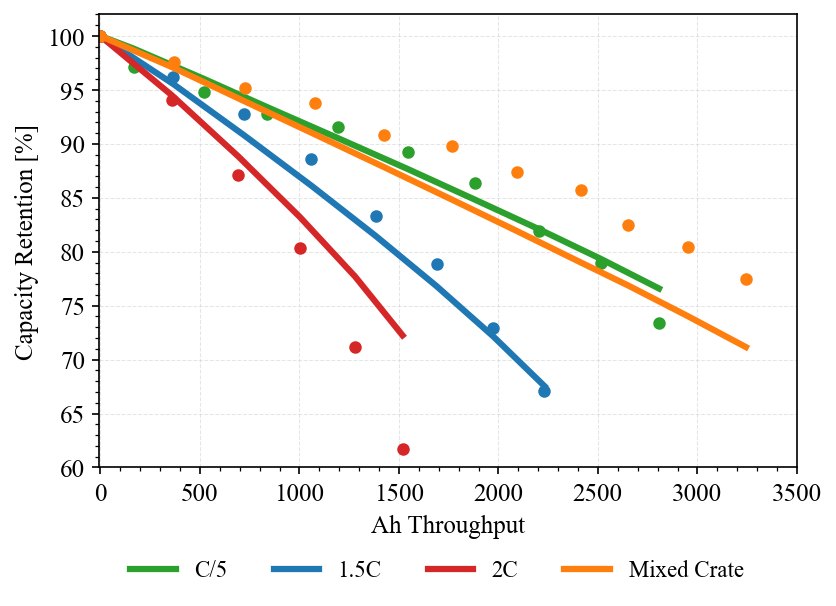

In [7]:
cells = [1,4,7,10]
sno = 7
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors =["tab:green","tab:blue","tab:red","tab:orange","tab:grey"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
# ax.set_title(r'C/20 Capacity')
ax.set_ylim([60,102])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_cap_1.png')
plt.show()

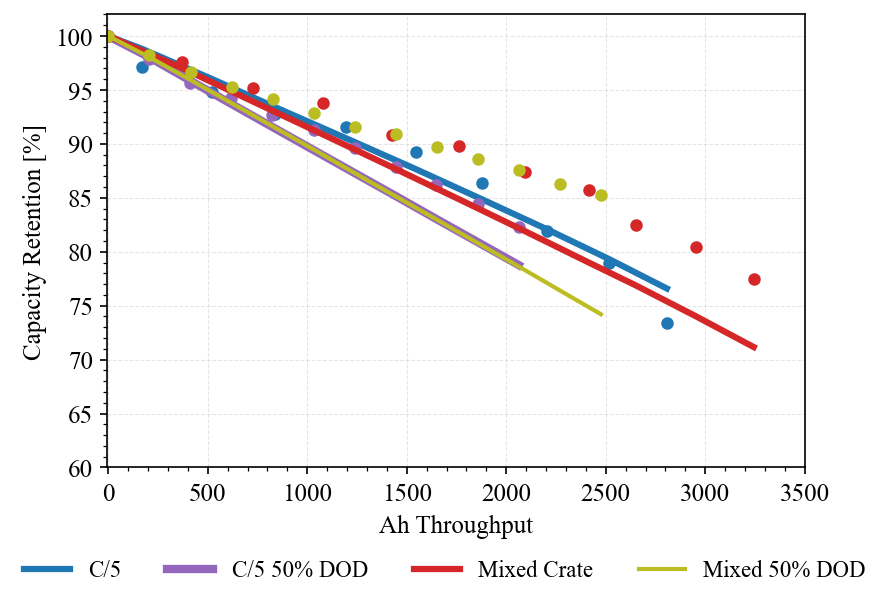

In [6]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=4)
    elif cell == 16:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=2)
    else:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
# ax.set_title(r'C/20 Capacity')
ax.set_ylim([60,102])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_cap_2.png')
plt.show()

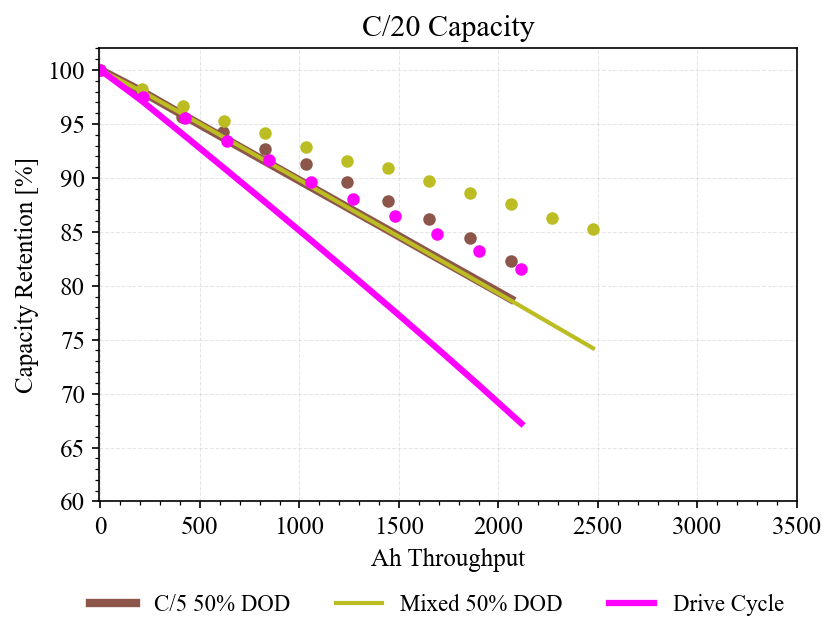

In [26]:
cells = [13,16,19]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:brown","tab:olive","magenta"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=4)
    elif cell == 16:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=2)
    else:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
ax.set_title(r'C/20 Capacity')
ax.set_ylim([60,102])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5 50% DOD','Mixed 50% DOD', 'Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_cap_S2.png')
plt.show()

In [ ]:
cells = [3,6,9,12]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
ax.set_title(r'C/20 Capacity')
ax.set_ylim([60,102])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_cap_1.png')
plt.show()

In [ ]:
cells = [3,15,12,18]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],dfe["Cap"]/dfe["Cap"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    if cell == 13:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=4)
    elif cell == 16:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=2)
    else:
        ax.plot(dfe["Ah_th"],df["Capacity [A.h]"][Ns]/df["Capacity [A.h]"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Capacity Retention [%]")
ax.set_title(r'C/20 Capacity')
ax.set_ylim([60,102])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_cap_2.png')
plt.show()

# Irreversible Expansion Plots

In [27]:
b1 = 737.578
b2 = 1004.319

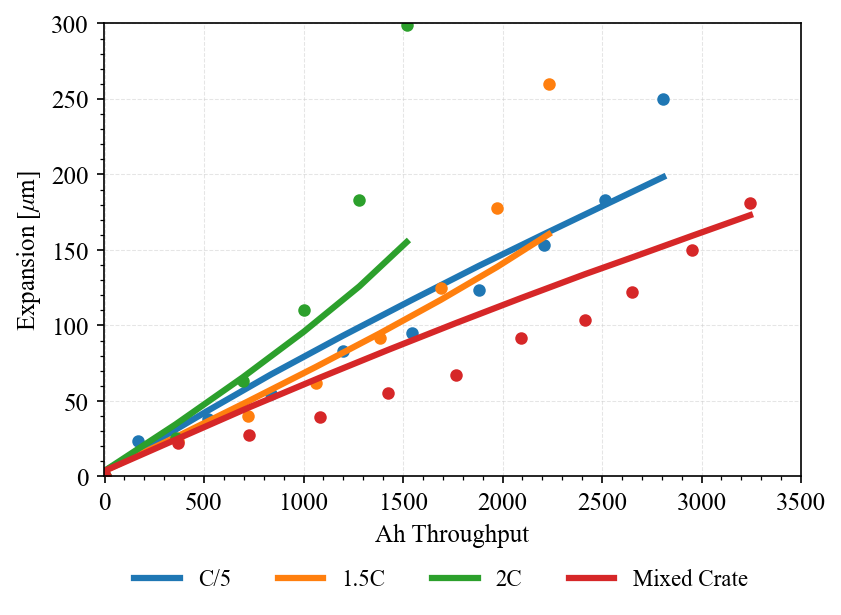

In [29]:
cells = [1,4,7,10]
sno = 7
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_1.png')
plt.show()

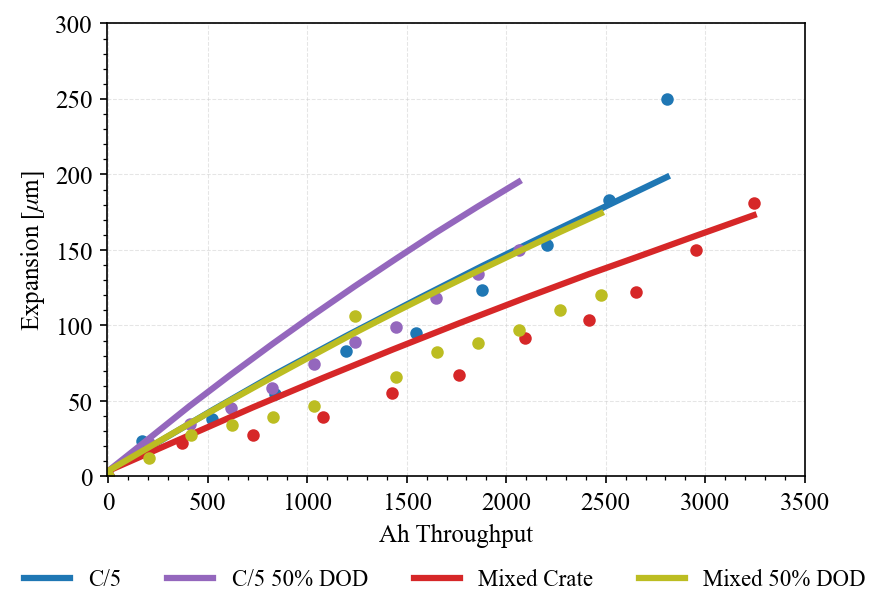

In [30]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_ylim([0,300])
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
# ax.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_expansion_2.png')
plt.show()

In [ ]:
cells = [3,6,9]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'Irreversible Expansion')
ax.set_ylim([0,160])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_expansion_1.png')
plt.show()

In [ ]:
cells = [3,15,18]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_ylim([0,200])
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'Irreversible Expansion')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_expansion_2.png')
plt.show()

In [ ]:
cells = [1,3]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    if cell%3 == 0:
        sim_des = f'cond{sno}'+'_sc_2'
    else:
        sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'C/5 Irreversible Expansion')
ax.set_ylim([0,250])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'C5_irrev_exp_comp.png')
plt.show()

In [ ]:
cells = [4,6]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    if cell%3 == 0:
        sim_des = f'cond{sno}'+'_sc_2'
    else:
        sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'1.5C Irreversible Expansion')
ax.set_ylim([0,250])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'1p5C_irrev_exp_comp.png')
plt.show()

In [ ]:
cells = [7,9]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    if cell%3 == 0:
        sim_des = f'cond{sno}'+'_sc_2'
    else:
        sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    del_sei = df["X-averaged SEI thickness [m]"]
    del_li = df["X-averaged lithium plating thickness [m]"]
    irrev_exp = 1e6*(b1*del_sei + b2*del_li)
    ax.plot(dfe["Ah_th"],dfe["irrev_exp"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(dfe["Ah_th"],irrev_exp[Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Expansion [$\mu$m]")
ax.set_title(r'2C Irreversible Expansion')
ax.set_ylim([0,250])
# ax.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'2C_irrev_exp_comp.png')
plt.show()

# Resistance Plots

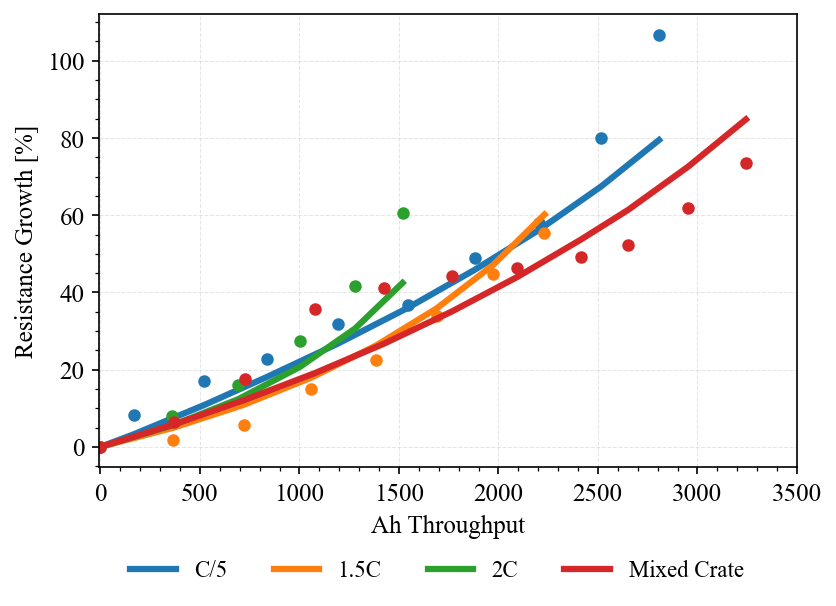

In [8]:
cells = [1,4,7,10]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
# ax.set_title(r'Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_resistance_1.png')

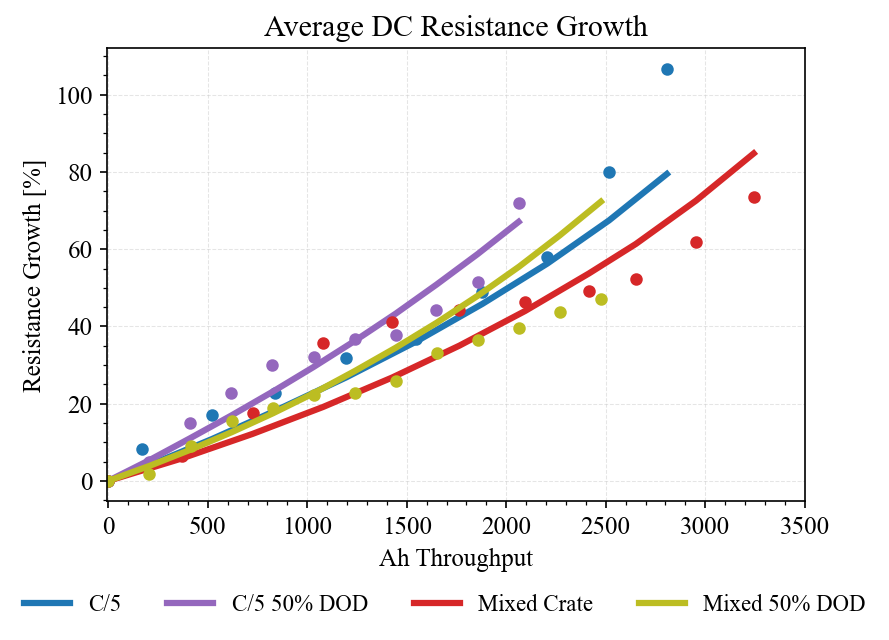

In [9]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_room_resistance_2.png')

In [ ]:
cells = [3,6,9,12]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_resistance_1.png')

In [ ]:
cells = [3,15,12,18]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','C/5 50% DOD','Mixed Crate','Mixed 50% DOD'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'cycling_aging_hot_resistance_2.png')

In [ ]:
cells = [1,3]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'C/5 Aging: Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'C5_resistance_comp.png')

In [ ]:
cells = [4,6]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'1.5C Aging: Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'1p5C_resistance_comp.png')

In [ ]:
cells = [7,9]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'2C Aging: Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'2C_resistance_comp.png')

In [ ]:
cells = [10,12]
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:
    cell_no = f'{cell:02d}'
    df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
    ax.plot(df["Ah_th"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax.plot(df["Ah_th"],(df["Rs_sim"]-df["Rs_sim"][0])/df["Rs_sim"][0]*100,color=colors[i],linewidth=3)
    i+=1
# ax.set_xlim([-5,3500])
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r'Resistance Growth [%]')
ax.set_title(r'Mixed Crate Aging: Average DC Resistance Growth')
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['Room','Hot','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
plt.savefig(fig_DIR +'mixedC_resistance_comp.png')

# SEI Plots

In [ ]:
cells = [1,3]
sno = 7
sim_des = f'cond{sno}'+'_sc_2'
fig, ax = plt.subplots(1,1,figsize=(6,4))
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:green","tab:red","tab:green","tab:red","tab:purple","tab:brown","tab:cyan"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    if cell%3 == 0:
        sim_des = f'cond{sno}'+'_sc_2'
    else:
        sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax.plot(dfe["Ah_th"],1e9*df["X-averaged SEI thickness [m]"][Ns],color=colors[i],linewidth=3)
    i+=1
ax.set_xlabel('Ah Throughput')
ax.set_ylabel(r"Thickness [nm]")
ax.set_title(r'SEI Thickness')
# ax.set_ylim([60,102])
# ax.set_xlim([-5,3500])
fig.legend(['Room','Hot'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
# plt.savefig(fig_DIR +'cycling_aging_hot_cap_1.png')
plt.show()

# Degradation Modes

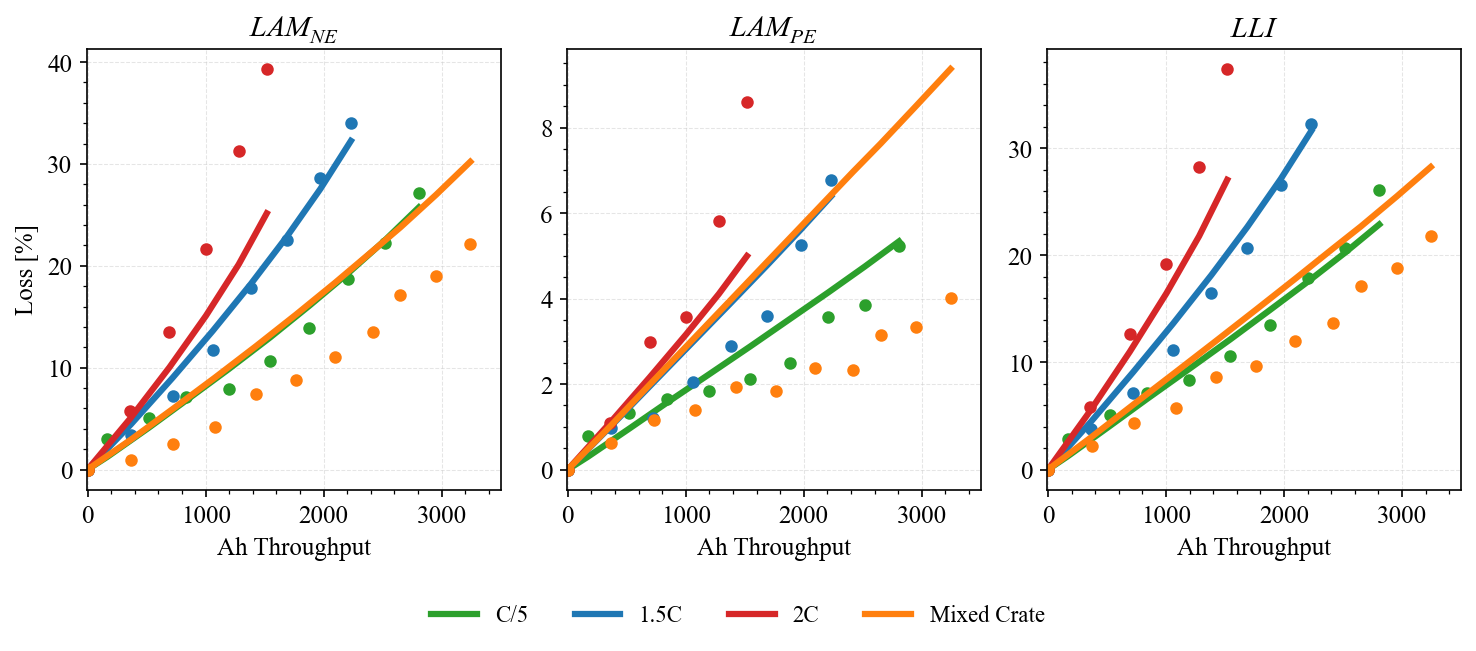

In [24]:
cells = [1,4,7,10]
sno = 7
sim_des = f'cond{sno}'
fig, ax = plt.subplots(1,3,figsize=(10,4),sharex=True)
i = 0
markers = ["o","v","^","1","*","d","p"]
colors =["tab:green","tab:blue","tab:red","tab:orange","tab:grey"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax1 = ax.flat[0]
    ax1.plot(dfe["Ah_th"],(dfe["C_n"][0]-dfe["C_n"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    ax2 = ax.flat[1]
    ax2.plot(dfe["Ah_th"],(dfe["C_p"][0]-dfe["C_p"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    ax3 = ax.flat[2]
    ax3.plot(dfe["Ah_th"],dfe["Loss of lithium inventory [%]"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],color=colors[i],linewidth=3)
    i+=1
ax1.set_xlabel('Ah Throughput')
ax2.set_xlabel('Ah Throughput')
ax3.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Loss [%]")
ax1.set_title(r'$LAM_{NE}$')
ax2.set_title(r'$LAM_{PE}$')
ax3.set_title(r'$LLI$')
# ax.set_ylim([60,102])
ax1.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
fig.tight_layout()
plt.savefig(fig_DIR +'cycling_aging_room_deg_mode_1.png')
plt.show()

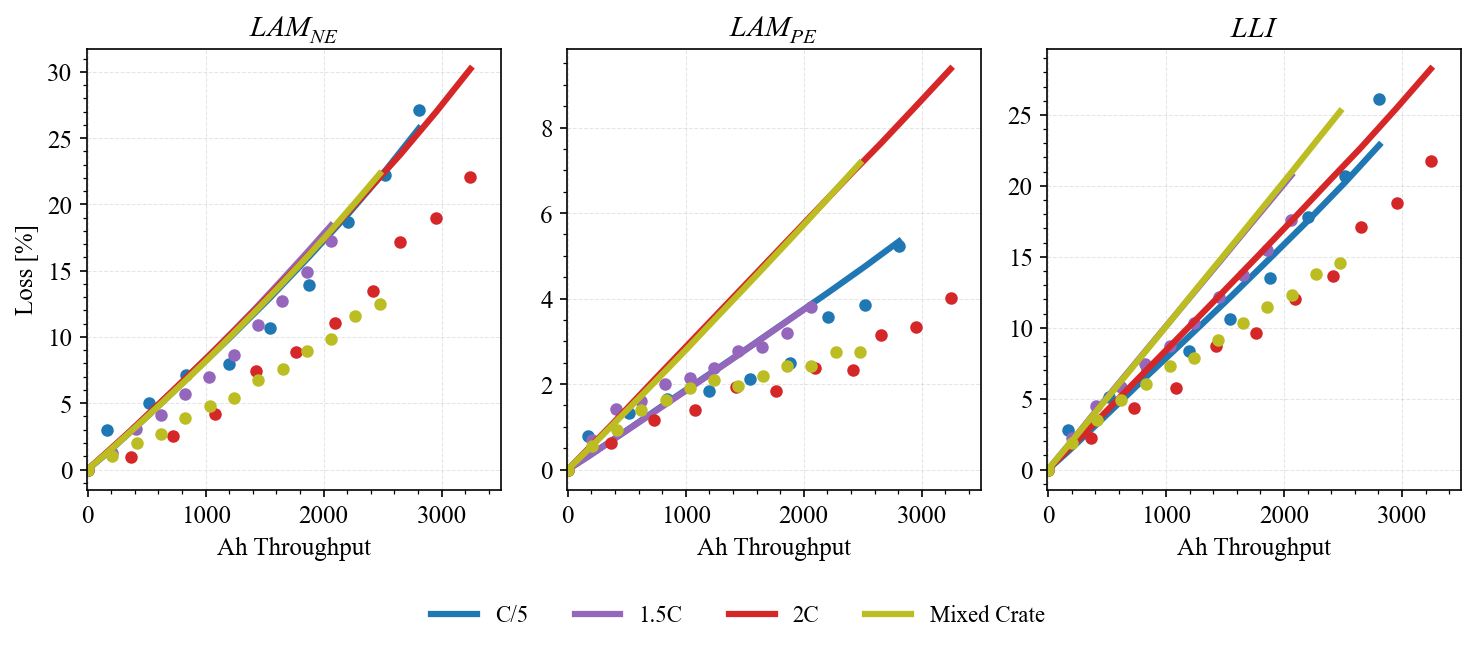

In [25]:
cells = [1,13,10,16]
fig, ax = plt.subplots(1,3,figsize=(10,4),sharex=True)
i = 0
markers = ["o","v","^","1","*","d","p"]
colors = ["tab:blue","tab:purple","tab:red","tab:olive"]
for cell in cells:    
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    Ns = np.insert(N[1:]-1,0,0)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        df = pickle.load(handle)
    ax1 = ax.flat[0]
    ax1.plot(dfe["Ah_th"],(dfe["C_n"][0]-dfe["C_n"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax1.plot(dfe["Ah_th"],(df["C_n"][0]-df["C_n"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    ax2 = ax.flat[1]
    ax2.plot(dfe["Ah_th"],(dfe["C_p"][0]-dfe["C_p"])/dfe["C_n"][0]*100,linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax2.plot(dfe["Ah_th"],(df["C_p"][0]-df["C_p"][Ns])/df["C_n"][0]*100,color=colors[i],linewidth=3)
    ax3 = ax.flat[2]
    ax3.plot(dfe["Ah_th"],dfe["Loss of lithium inventory [%]"],linestyle="None",marker="o",label='_nolegend_',color=colors[i])
    ax3.plot(dfe["Ah_th"],df["Loss of lithium inventory [%]"][Ns],color=colors[i],linewidth=3)
    i+=1
ax1.set_xlabel('Ah Throughput')
ax2.set_xlabel('Ah Throughput')
ax3.set_xlabel('Ah Throughput')
ax1.set_ylabel(r"Loss [%]")
ax1.set_title(r'$LAM_{NE}$')
ax2.set_title(r'$LAM_{PE}$')
ax3.set_title(r'$LLI$')
# ax.set_ylim([60,102])
ax1.set_xlim([-5,3500])
# ax.legend(['C/5','1.5C','2C','Mixed Crate','C/5 50% DOD','Mixed 50% DOD','Drive Cycle'])
fig.legend(['C/5','1.5C','2C','Mixed Crate'], 
            loc="lower center",bbox_to_anchor=[0.5,-0.10], ncol=4, fontsize=11)
fig.tight_layout()
plt.savefig(fig_DIR +'cycling_aging_room_deg_mode_2.png')
plt.show()

In [19]:
df

{'Minimum measured discharge capacity [A.h]': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [11]:
dfe

,N,Ah_th,x_0,y_0,x_100,y_100,C_n,C_p,Cap,Rs_ave,N_mod,Capacity [A.h],n_Li,Loss of lithium inventory [%],Capacity Retention [%],rev_exp,irrev_exp
0,0,0.000000,-0.000185,0.867248,0.816712,0.033487,5.714103,5.598534,4.694385,0.009386,0,4.694385,0.181119,0.000000,100.000000,96.2,0.0
1,41,368.160573,-0.000414,0.853617,0.805715,0.033473,5.660294,5.563563,4.583082,0.010000,40,4.583082,0.177110,2.213424,97.629002,88.2,22.1
2,82,726.238971,-0.000616,0.840100,0.800626,0.033468,5.570206,5.532978,4.469921,0.011042,81,4.469921,0.173305,4.314376,95.218442,91.8,27.5
3,123,1080.711788,-0.000752,0.830038,0.802166,0.033469,5.474932,5.518570,4.402450,0.012729,122,4.402450,0.170756,5.721816,93.781172,93.4,39.3
4,164,1426.911370,-0.001008,0.808640,0.803169,0.033470,5.290541,5.488514,4.264664,0.013245,163,4.264664,0.165398,8.680174,90.846053,90.1,55.1
5,205,1764.959703,-0.001108,0.799272,0.806518,0.033473,5.209444,5.493984,4.214123,0.013539,204,4.214123,0.163626,9.658355,89.769421,93.6,67.0
6,246,2094.826105,-0.001268,0.782889,0.804334,0.033471,5.082216,5.463228,4.102756,0.013744,245,4.102756,0.159344,12.022380,87.397082,84.0,91.8
7,287,2415.620396,-0.001397,0.768272,0.810894,0.033479,4.943434,5.464819,4.023657,0.014012,286,4.023657,0.156393,13.651904,85.712124,86.0,103.3
8,317,2651.237220,-0.001592,0.744045,0.812090,0.033480,4.732346,5.419100,3.873029,0.014287,316,3.873029,0.150160,17.092925,82.503439,80.1,122.0
9,358,2953.526558,-0.001694,0.730314,0.812095,0.033480,4.630313,5.407463,3.776566,0.015197,357,3.776566,0.147055,18.807361,80.448580,76.6,149.9


# eSOH Plots

In [ ]:
def plotc2_cap(all_sumvars_dict1,all_sumvars_dict2,esoh_data,leg1="sim1",leg2="sim2"):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    name = "Capacity [A.h]"
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"b--")
    ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"r--")
    ax.plot(esoh_data["N"],esoh_data[name],"kx")
    ax.set_title(split_long_string(name))
    ax.set_xlabel("Cycle number")
    fig.legend([leg1, leg2 , "Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=3, fontsize=11)
    fig.tight_layout()
    return fig

In [33]:
sno = 7
sim_des = f'cond{sno}'
cell = 1
cell_no,dfe1,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    data1 = pickle.load(handle)
cell = 4
cell_no,dfe2,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
# fig.savefig(fig_DIR +'com_exch_current_cell_'+cell_no+'_eSOH.png')

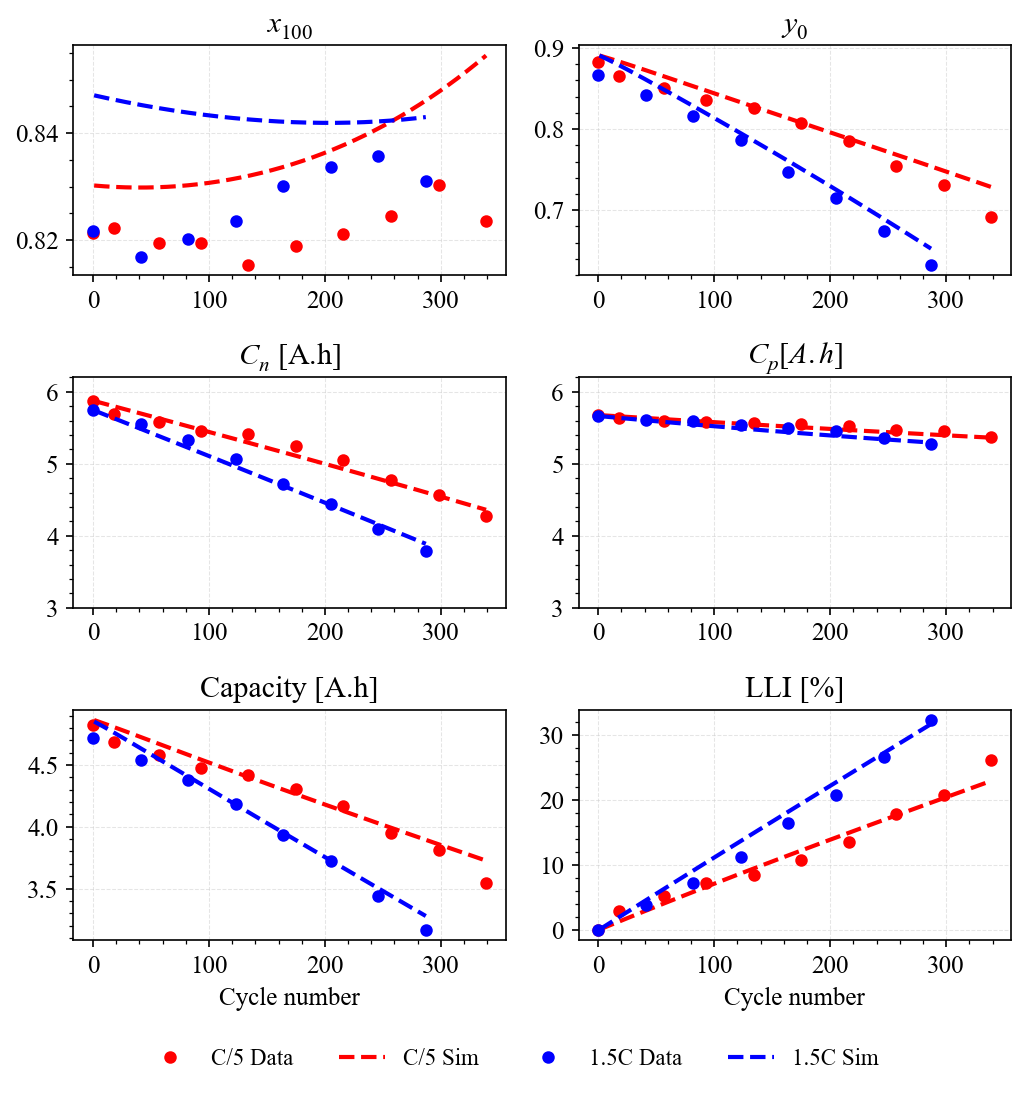

In [39]:
esoh_data = dfe1
esoh_data_2 = dfe2
all_sumvars_dict1 = data1
all_sumvars_dict2 = data2
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
titles = [r"$x_{100}$",r"$y_0$",r"$C_n$ [A.h]",r"$C_p [A.h]$", "Capacity [A.h]", "LLI [%]"]
fig, axes = plt.subplots(3,2,figsize=(7,7))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(esoh_data["N"],esoh_data[name],"ro")
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"r--")
    ax.plot(esoh_data_2["N"],esoh_data_2[name],"bo")
    ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"b--")
    ax.set_title(titles[k])
    if k ==2 or k==3:
        ax.set_ylim([3,6.2])
    if k>3:
        ax.set_xlabel("Cycle number")
fig.legend(["C/5 Data","C/5 Sim","1.5C Data","1.5C Sim" ], 
        loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=4, fontsize=11)
fig.tight_layout()
fig.savefig(fig_DIR +'cycling_aging_1_4.png')

In [42]:
sim_des = f'cal'
cell = 22
cell_no,dfe1,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    data1 = pickle.load(handle)
cell = 24
cell_no,dfe2,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
# fig.savefig(fig_DIR +'com_exch_current_cell_'+cell_no+'_eSOH.png')

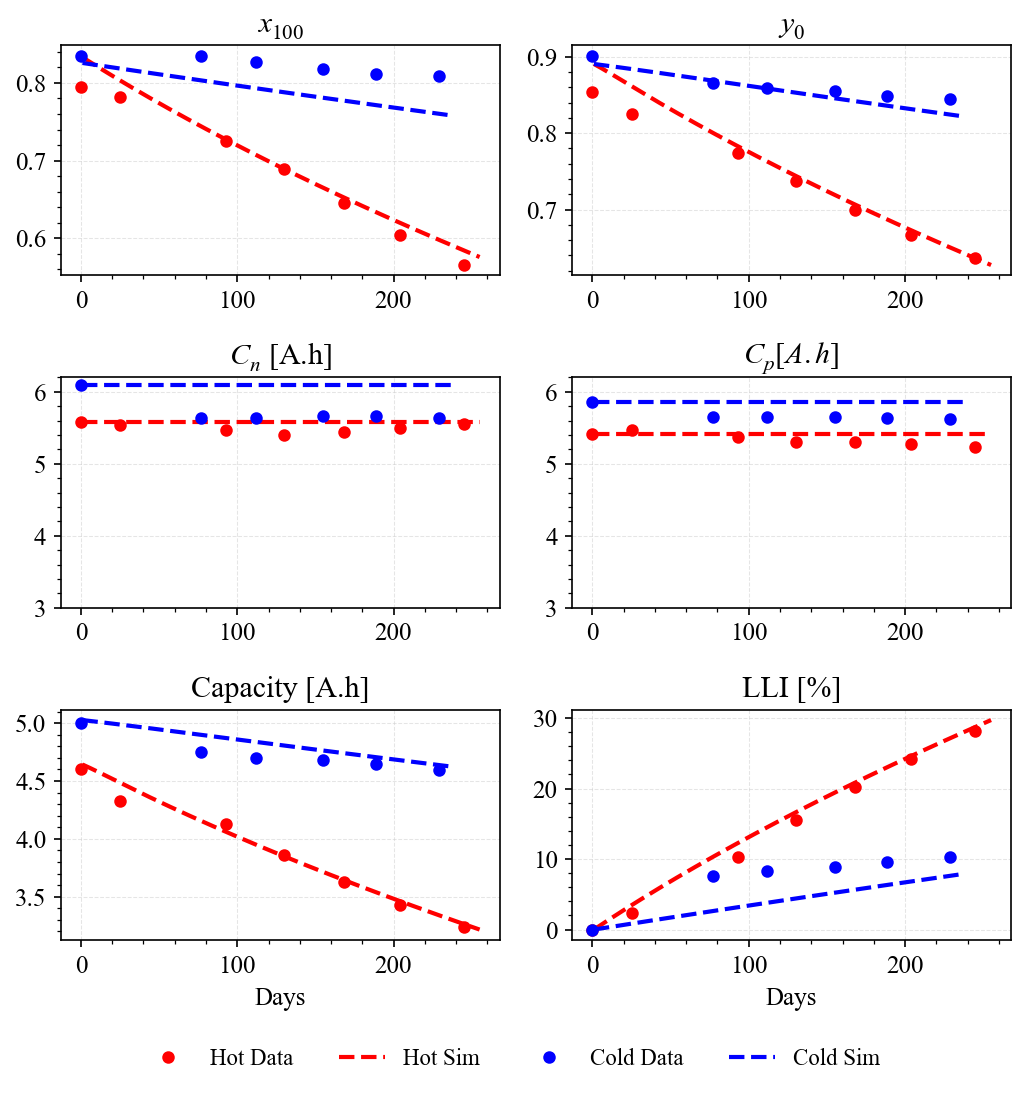

In [43]:
esoh_data = dfe1
esoh_data_2 = dfe2
all_sumvars_dict1 = data1
all_sumvars_dict2 = data2
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
titles = [r"$x_{100}$",r"$y_0$",r"$C_n$ [A.h]",r"$C_p [A.h]$", "Capacity [A.h]", "LLI [%]"]
fig, axes = plt.subplots(3,2,figsize=(7,7))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.plot(esoh_data["N"],esoh_data[name],"ro")
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"r--")
    ax.plot(esoh_data_2["N"],esoh_data_2[name],"bo")
    ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"b--")
    ax.set_title(titles[k])
    if k ==2 or k==3:
        ax.set_ylim([3,6.2])
    if k>3:
        ax.set_xlabel("Days")
fig.legend(["Hot Data","Hot Sim","Cold Data","Cold Sim" ], 
        loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=4, fontsize=11)
fig.tight_layout()
fig.savefig(fig_DIR +'calendar_aging_1.png')